Load Libraries

In [25]:
import pandas as pd
import numpy as np

# Python Reddit API wrapper 
import praw 

import datetime as dt
from pprint import pprint
from itertools import chain

# Natural Language Toolkit
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

import re

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')

from wordcloud import WordCloud

Download Databases

In [26]:
# contains the sentiments of specific texts
nltk.download('vader_lexicon')
# pre-trained models that help us tokenize sentences
nltk.download('punkt')
# datasets of common stopwords in English
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/donghyunsuh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/donghyunsuh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/donghyunsuh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Setting up Reddit Client

In [27]:
reddit = praw.Reddit(user_agent='sudanny',
                client_id='HihCAcoRAmiWpz295ugBHQ',
                client_secret='UDlPzMqVWLBKgiHCuZ5SIdCa6dENqQ',
                check_for_async=False)

Selecting Subreddit and Creating a Dataframe

In [28]:
submission = reddit.submission("t003vl")

comments = []

submission.comments.replace_more(limit=0)
for top_level_comment in submission.comments:
    comments.append(top_level_comment.body)

In [29]:
news= pd.DataFrame({"comment" : comments})
news.head()

,comment
0,The comments in this thread are sorted by new ...
1,"Sad day for humanity, there are no good outcom..."
2,"Verified sources, as per WorldNews for all wor..."
3,Explosions were reported near Kyiv.... \n\nhtt...
4,Per CNN: Belarusian troops are joining Russian...


Sentiment Analysis with VADER

In [30]:
sid = SentimentIntensityAnalyzer()
res = [*news['comment'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.6369, 'neg': 0.0, 'neu': 0.865, 'pos': 0.135},
 {'compound': -0.9371, 'neg': 0.627, 'neu': 0.274, 'pos': 0.099},
 {'compound': -0.8205, 'neg': 0.134, 'neu': 0.826, 'pos': 0.041}]


In [31]:
sentiment_df = pd.DataFrame.from_records(res)
news = pd.concat([news, sentiment_df], axis=1, join="inner")
news.head()

,comment,neg,neu,pos,compound
0,The comments in this thread are sorted by new ...,0.000,0.865,0.135,0.6369
1,"Sad day for humanity, there are no good outcom...",0.627,0.274,0.099,-0.9371
2,"Verified sources, as per WorldNews for all wor...",0.134,0.826,0.041,-0.8205
3,Explosions were reported near Kyiv.... \n\nhtt...,0.000,1.000,0.000,0.0000
4,Per CNN: Belarusian troops are joining Russian...,0.214,0.786,0.000,-0.4588


Choosing the threshold

In [32]:
THRESHOLD = 0.2

conditions = [
    (news['compound'] <= -THRESHOLD),
    (news['compound'] > -THRESHOLD) & (news['compound'] < THRESHOLD),
    (news['compound'] >= THRESHOLD)
]

values = ["neg", "neu", "pos"]
news['label'] = np.select(conditions, values)

news.head()

,comment,neg,neu,pos,compound,label
0,The comments in this thread are sorted by new ...,0.000,0.865,0.135,0.6369,pos
1,"Sad day for humanity, there are no good outcom...",0.627,0.274,0.099,-0.9371,neg
2,"Verified sources, as per WorldNews for all wor...",0.134,0.826,0.041,-0.8205,neg
3,Explosions were reported near Kyiv.... \n\nhtt...,0.000,1.000,0.000,0.0000,neu
4,Per CNN: Belarusian troops are joining Russian...,0.214,0.786,0.000,-0.4588,neg


In [33]:
news['label'].value_counts()

neg    163
neu     87
pos     74
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='Count'>

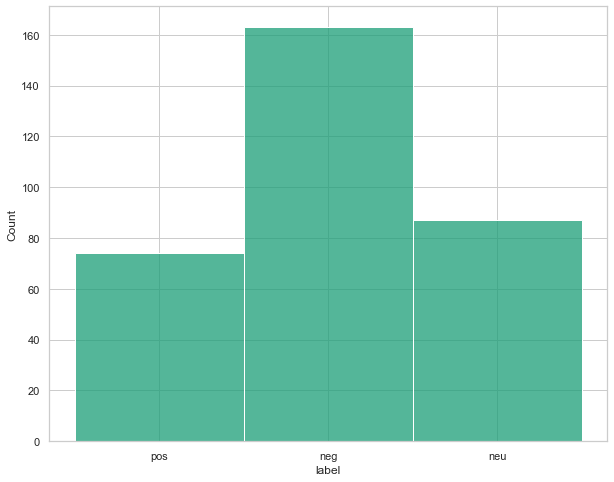

In [34]:
sns.histplot(news["label"]) # We have mostly negative comments and more positive comments than neutral ones

Accuracy of Labels

In [35]:
def news_comment_output(df, label):
    res = df[df['label'] == label].comment.values
    print(f'{"=" * 10}')
    print("\n".join(comment for comment in res))

# random sample
news_sub = news.groupby('label').sample(n=5, random_state=7)

print("Positive comments")
news_comment_output(news_sub, "pos")

print("\nNeutral comments")
news_comment_output(news_sub, "new")

print("\nNegative comments")
news_comment_output(news_sub, "neg")

Positive comments
My heart is breaking for all the innocent Ukrainians…
Waking up in Odessa because of rocket explosions nearby was totally not in my plans for the weekend.
As history books love, the invasions always starts at the dawn.
If this has been allowed, nothing will stop them from going after Moldova next.
What consequences will this have for the rest of Europe as well as the US and other countries?
According to nytimes (check the live updates), Ukrainian forces have shot down 6 Russian fighters and a helicopter according to an anonymous Ukraine military official.

(Edit: We only have info from Ukrainian forces, and Russia has a major advantage, so it’s very likely that we’re not getting the full picture)

Neutral comments


Negative comments
It’s crazy cuz the live stream of people evacuating makes me feel for and wonder how many parents are desperately tryna get their kids the fucc outta there
My god the sirens are so eerie
Live in a village near Russian border, situation ve

In [36]:
stop_words = stopwords.words('english')
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [37]:
example = "This is an example sentence! However, it isn't a very informative one"
tk = nltk.tokenize.RegexpTokenizer(r'\w+')
tokens = tk.tokenize(example)
print(tokens)

['This', 'is', 'an', 'example', 'sentence', 'However', 'it', 'isn', 't', 'a', 'very', 'informative', 'one']


Tokenization

In [38]:
def custom_tokenize(text):
    # change all comments to lower case
    text = text.lower()
    
    # remove numbers
    re.sub("[0-9]+", "", text)
    
    # split on words only
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tk.tokenize(text)
    
    # remove stop words
    words = [w for w in tokens if not w in stop_words]
    
    
    return words

In [39]:
def token_to_words(df, label):
    comments = df[df['label'] == label].comment
    tokens = comments.apply(custom_tokenize)
    words = list(chain.from_iterable(tokens))
    return words

pos_words = token_to_words(news, 'pos')
neg_words = token_to_words(news, 'neg')

remove_words = ['https', 'com', 'www', 'v', 'one', 'youtube', 'youtu']
neg_words = [word for word in neg_words if word not in remove_words]

Visualize Tokens

In [40]:
neg_freq = nltk.FreqDist(neg_words)
neg_freq.most_common(20)

[('putin', 58),
 ('ukraine', 55),
 ('russia', 46),
 ('war', 45),
 ('people', 31),
 ('russian', 24),
 ('watch', 22),
 ('fuck', 22),
 ('world', 20),
 ('live', 17),
 ('shit', 16),
 ('know', 15),
 ('like', 14),
 ('ukrainian', 13),
 ('hope', 13),
 ('kyiv', 12),
 ('fucking', 12),
 ('going', 12),
 ('hell', 11),
 ('sad', 10)]

Creating a WordCloud

In [41]:
def plot_word_cloud(words, colormap, stopwords = [], max_words = 100):
  text = " ".join(word for word in words)
  # generate word cloud 
  wordcloud = WordCloud(width=1000, height = 600,
                        max_words = max_words,
                        colormap=colormap,
                        stopwords = stopwords,
                        background_color="black").generate(text)

  # Display the generated image:
  plt.figure( figsize=(20,10), facecolor='k')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off");

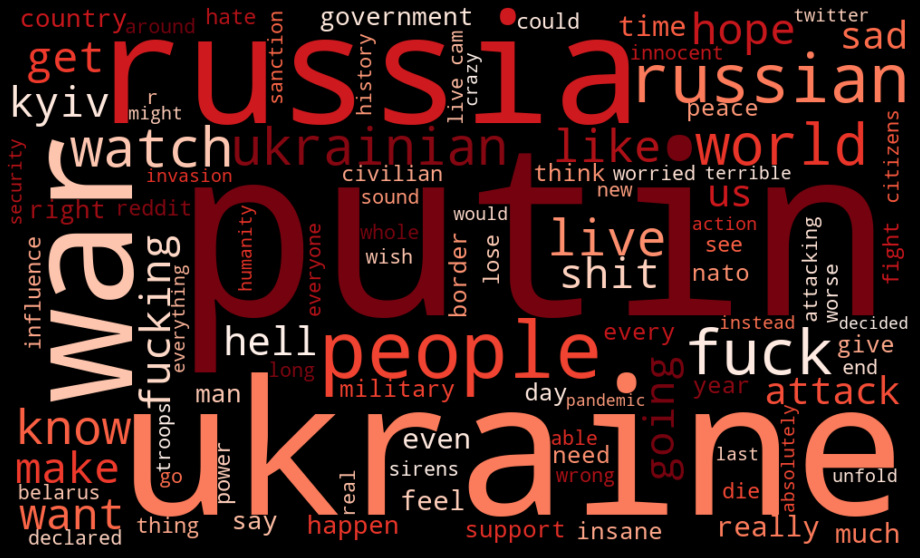

In [43]:
plot_word_cloud(neg_words, "Reds")